In [1]:
#Скачаем репозиторий проекта lime_imag и установим lime
!git clone https://github.com/marcotcr/lime.git
!pip install lime

fatal: destination path 'lime' already exists and is not an empty directory.


In [2]:
#Выполним импорт библиотек и модулей
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb #так как коду нужны цветные изображения

In [3]:
#Решим ошибку с импортом датасета mnist.data 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
#Сделаем каждое изображение цветным, чтобы lime_image работал корректно
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.values.astype(np.uint8).reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

C:\Users\lvlkv\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Digit: 5')

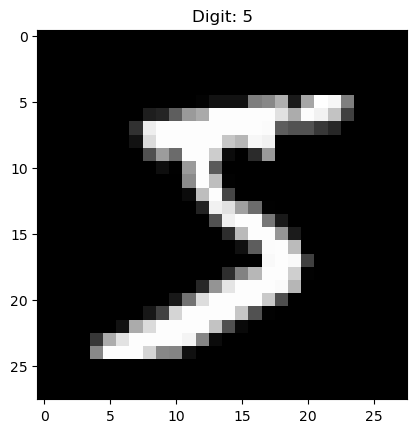

In [4]:
#Визуализируем цифру
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

In [5]:
#Выполним задание по определению пикселей, влияющих на преобразование одного класса данных в другой
#Создадим конвеер для обработки изображений
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Оболочка для преобразования функций в конвейерные преобразования (без подгонки)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [6]:
#Разделим данные на обучающий (55%) и тестовый (45%) наборы
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

In [7]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x000001FAFF63E750>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x000001FAFF614B50>),
                ('RF', RandomForestClassifier())])

In [8]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # добавим текущий каталог
    import lime

In [9]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [10]:
%%time
explanation = explainer.explain_instance(X_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 7.23 s
Wall time: 7.12 s


Text(0.5, 1.0, 'Positive/Negative Regions for 0')

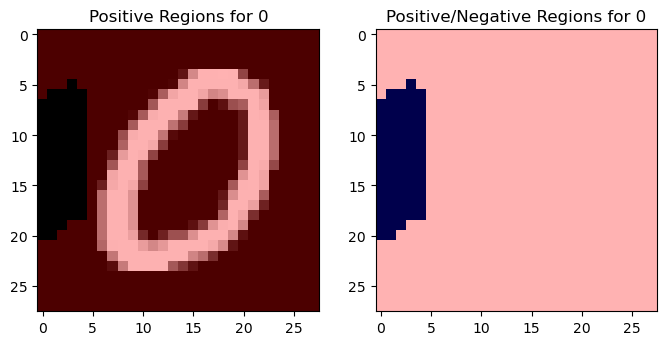

In [11]:
#На первом изображении только положительные области, на втором положительные и отрицательные области
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test.iloc[0]))
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test.iloc[0]))

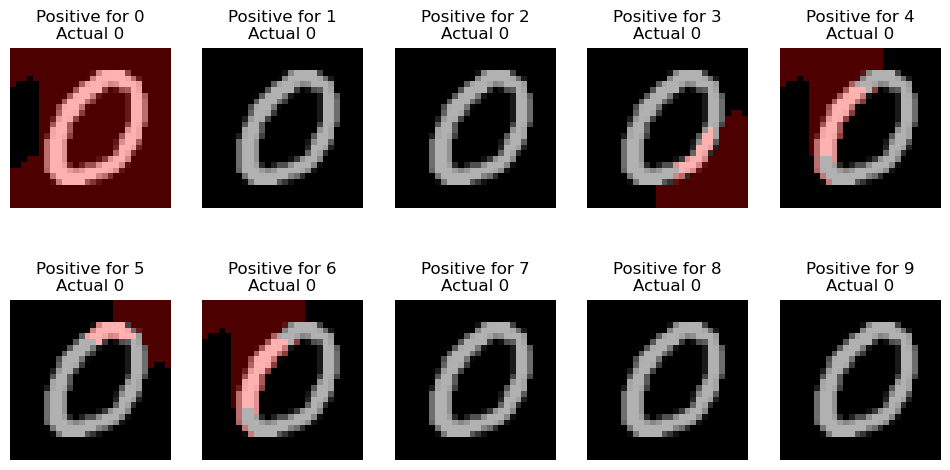

In [12]:
#Покажем влияние каждого класса на классификацию конкретного изображения
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,X_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[0]))
    c_ax.axis('off')
     

In [14]:
#Идентифицируем случаи совершения ошибки в предсказаниях
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #26169 where the label was 7 and the pipeline predicted 4


In [15]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 7.38 s
Wall time: 7.23 s


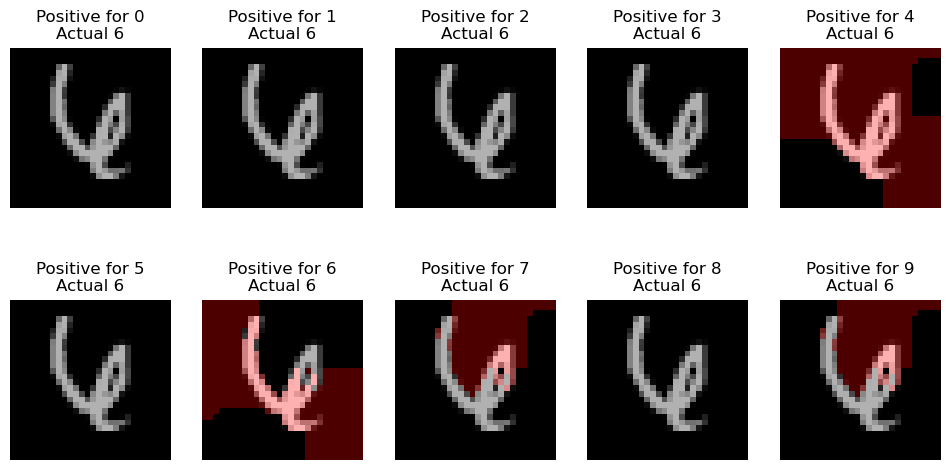

In [16]:
# теперь покажем их для каждого класса
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test.iloc[wrong_idx]))
    c_ax.axis('off')